# Mobility in shopping centers during COVID-19 crises

Many malls had to close their doors to costumers in order to prevent the spread of coronavirus from worsening. But these measures were heterogeneous within Brazil, some states already allowed shopping centers and others nonessential business to reopen whereas they are still closed in anothers.

This study aims to show how different open companies in brazilian real state (BR Malls and Iguatemi) are suffering during the pandemic by using scrapped Google Maps mobility data. 

In [31]:
# =============================================================================
# Importing libraries
# =============================================================================

# Data handling
import pandas as pd
import numpy as np

# SQL
from sqlalchemy import create_engine

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import gridspec
import seaborn as sns

plt.style.use('fivethirtyeight') # Setting default visualization

# Dates
from datetime import datetime as dt

ct_date = dt.today().strftime("%m-%d-%y")
dts = pd.date_range(start = '03-27-2020', end = ct_date, freq = 'D').strftime("%m_%d_%y")

# Others
from IPython.display import HTML
from tqdm.notebook import tqdm_notebook, tqdm
from math import ceil

# =============================================================================
# Built-in functions
# =============================================================================

# 
def byHour(tbdict, company, day):
    
    ''' Aggregate data by hour '''
    
    day_of_week = {
        0:'segunda',
        1:'terça',
        2:'quarta',
        3:'quinta',
        4:'sexta',
        5:'sabado',
        6:'domingo'
    }
    
    output_live1 = tbdict[company]\
        .assign(time_collected_day = lambda x: x.time_collected.dt.strftime('%Y-%m-%d'), popular = lambda x: x.popular.apply(pd.to_numeric))\
        .query('live == 1 and time_collected_day == @day')\
        .pivot_table(index = 'place', columns = 'hour_text', values = 'popular')
    
    dayofweek = day_of_week.get(pd.to_datetime(day).dayofweek)
    
    output_live0 = tbdict[company]\
        .assign(time_collected_day = lambda x: x.time_collected.dt.strftime('%Y-%m-%d'), popular = lambda x: x.popular.apply(pd.to_numeric))\
        .query('live == 0 and time_collected_day == @day and day == @dayofweek')\
        .pivot_table(index = 'place', columns = 'hour_text', values = 'popular')
    
    return output_live1, output_live0

# Ocupation rate
def ocupationRate(tbdict, key, shoppings):
    
    ''' This function computes ocupation rate for each mall of a given company '''
    
    day_of_week = {
        0:'segunda',
        1:'terça',
        2:'quarta',
        3:'quinta',
        4:'sexta',
        5:'sabado',
        6:'domingo'
    }
    
    tbdict[key] = tbdict[key].assign(popular = lambda x: x.popular.apply(pd.to_numeric))
    
    # Usual and atual data
    s0_temp = []
    for index, row in tbdict[key].query('live == 0').assign(dow = lambda x: x.time_collected.dt.dayofweek.apply(day_of_week.get)).iterrows():
        if row.day == row.dow:
            s0_temp.append(row)
    s0 = pd.concat(s0_temp, axis = 1).T.assign(popular = lambda x: x.popular.apply(pd.to_numeric))\
            .pivot_table(index = 'place', columns = [pd.Grouper(key = 'time_collected', freq = 'D'), 'hour_text'], values = 'popular')
    
    s1 = tbdict[key].query('live == 1').pivot_table(index = 'place', columns = [pd.Grouper(key = 'time_collected', freq = 'D'), 'hour_text'], values = 'popular')
    
    temp = s1.div(s0).T.query('time_collected >= @pd.to_datetime("2020-04-28")')\
            .reset_index().replace([np.inf, -np.inf], np.nan).groupby('time_collected').mean().T
        
    shop = shoppings.query('company == @key')[['local']].set_index('local')
    
    output = shop.merge(temp, left_index = True, right_index = True, how = 'outer')
        
    return output

def weightedMean(tb, path, name):
    
    ''' Computes the weighted average ocupation rate for a given company '''
    
    merged = pd.read_excel(path)[['shopping', 'sales_419']]\
                .set_index(['shopping']).merge(tb, left_index = True, right_index = True)
    
    xx2 = merged.applymap(lambda x: True if not np.isnan(x) else False)\
                .apply(lambda x: merged.sales_419 * x).drop('sales_419', axis = 1)
    
    xx3 = merged.apply(lambda x: merged.sales_419 * x).drop('sales_419', axis = 1)
    
    output = pd.DataFrame(xx3.sum()).T / pd.DataFrame(xx2.sum()).T
    output.index = [name]
    
    return output

### Loading files

In [12]:
# =============================================================================
# Loading files
# =============================================================================

# List of shopping centers for each company
iguatemi = pd.read_excel('D:/Projetos/google_maps/other_files/iguatemi_keys.xlsx')
brmalls = pd.read_excel('D:/Projetos/google_maps/other_files/brmalss_keys.xlsx')

shoppings = iguatemi[['local', 'place_id']].assign(company = 'iguatemi')\
                .append(brmalls[['local', 'place_id']].assign(company = 'brmalls')) # Appending the lists

# Market share by shooping center
iguatemi_receita_shopping_sales419 = pd.read_excel('D:/Projetos/google_maps/auxiliar/iguatemi_receita_shopping.xlsx')\
    .set_index('shopping')\
    .filter(['sales_419'])\
    .assign(sales_419 = lambda x: x['sales_419'] / x['sales_419'].sum() * 100)

brmalls_receita_shopping_sales419 = pd.read_excel('D:/Projetos/google_maps/auxiliar/brmalls_receita_shopping.xlsx')\
    .set_index('shopping')\
    .filter(['sales_419'])\
    .assign(sales_419 = lambda x: x['sales_419'] / x['sales_419'].sum() * 100)

# Loading from SQL files
tbs_query = []
for date in tqdm_notebook(dts):
    
    ''' Loading data for brMalls and Iguatemi shopping centers '''
    
    engine = create_engine(f'sqlite:///D:/Users/gusta/Documents/google_maps/databases/google_live_{date}.db')
    query_string = 'SELECT * from google_live WHERE place_id in (' + ', '.join(['"' + x + '"' for x in shoppings.place_id.tolist()]) + ')'
    temp = pd.read_sql_query(query_string, engine)
    tbs_query.append(temp)

tb = pd.concat(tbs_query, axis = 0).assign(time_collected = lambda x: x.time_collected.apply(pd.to_datetime))

In [15]:
# =============================================================================
# Restructing data
# =============================================================================

# Creating a dictionary - this will make it easier to call for specific data
tbdict = {
    'iguatemi':tb.query('place_id == @iguatemi.place_id.tolist()'),
    'brmalls':tb.query('place_id == @brmalls.place_id.tolist()')
}

# Getting ocupation rate
iguatemi_ocpRate, brmalls_ocpRate = ocupationRate(tbdict, 'iguatemi', shoppings), ocupationRate(tbdict, 'brmalls', shoppings)

# % vendas por shopping
iguatemi_receita_shopping_sales419 = pd.read_excel('D:/Projetos/google_maps/auxiliar/iguatemi_receita_shopping.xlsx')\
    .set_index('shopping')\
    .filter(['sales_419'])\
    .assign(sales_419 = lambda x: x['sales_419'] / x['sales_419'].sum() * 100)

brmalls_receita_shopping_sales419 = pd.read_excel('D:/Projetos/google_maps/auxiliar/brmalls_receita_shopping.xlsx')\
    .set_index('shopping')\
    .filter(['sales_419'])\
    .assign(sales_419 = lambda x: x['sales_419'] / x['sales_419'].sum() * 100)

In [262]:
def indexTb(tb, key_):
    
    # ========================================================================================================
    # # Load libraries
    # ========================================================================================================
    
    capitais2 = [
        'São Paulo - SP', 'Brasília - DF', 'Rio Branco - AC', 'Maceió - AL', 'Macapá - AP',
        'Manaus - AM', 'Salvador - BA', 'Fortaleza - CE', 'Vitória - ES', 'Goiânia - GO',
        'São Luís - MA', 'Cuiabá - MT', 'Campo Grande - MS', 'Belo Horizonte - MG', 'Belém - PA',
        'João Pessoa - PB', 'Curitiba - PR', 'Recife - PE', 'Teresina - PI', 'Rio de Janeiro - RJ',
        'Natal - RN', 'Porto Alegre - RS', 'Porto Velho - RO', 'Boa Vista - RR', 'Florianópolis - SC',
        'Aracaju - SE', 'Palmas - TO'
    ]
    
    pib_proporcional = pd.read_excel('auxiliar/pib_proporcional.xlsx')
    capital_uf = pd.DataFrame({'key':[x.split(' - ')[1] for x in capitais2], 'value':capitais2})
    uf_dict = pib_proporcional.merge(capital_uf, left_on = 'uf', right_on = 'key')[['value', 'proporcional']]\
                .set_index('value').to_dict()['proporcional']
    
    # ========================================================================================================
    # # Load libraries
    # ========================================================================================================
    
    columns_ = ['hour_text', 'day', pd.Grouper(key = 'time_collected', freq = 'D'), 'place_id', 'place', 'city']
    
    tbdict[key_][['popular', 'live']] = tbdict[key_][['popular', 'live']].astype(int)
    tr = tb[key_].pivot_table(index = columns_, columns = 'live', values = 'popular').reset_index()
    tr_ = tr.loc[~tr[1].isna()].loc[tr[1] > 0]
    
    output = tr_\
            .melt(id_vars = ['hour_text', 'day', 'city', 'time_collected', 'place_id', 'place'], value_name = 'popular')\
            .groupby([pd.Grouper(key = 'time_collected', freq = 'D'), 'city', 'live']).sum().reset_index()\
            .pivot_table(index = ['time_collected', 'city'], columns = 'live', values = 'popular').reset_index()\
            .assign(prop = lambda x: x.city.apply(uf_dict.get), 
                    Usual = lambda x: x[0] * x.prop, 
                    Atual = lambda x: x[1] * x.prop)\
            .groupby([pd.Grouper(key = 'time_collected', freq = 'D')])[['Usual', 'Atual']].sum()
    
    # ========================================================================================================
    # # Sample number per hour
    # ========================================================================================================
    
    return output

### Charts
Each company index is weighted by its shopping centers sales.

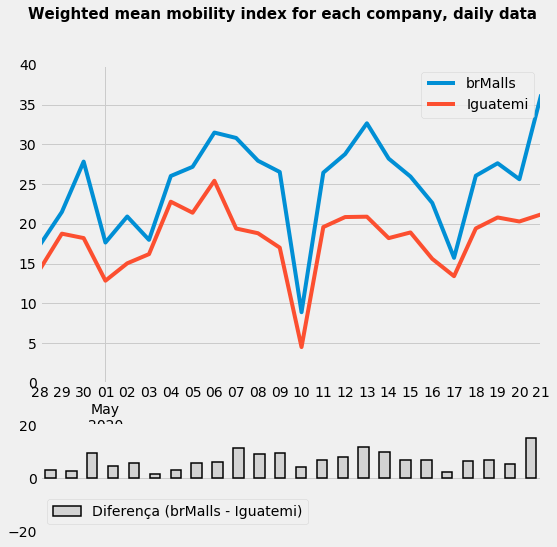

In [19]:
# =============================================================================
# Chart - Weighted mean ocupation rate
# =============================================================================

# Computing the weighted mean for each company
iguatemi_weighted_mean = weightedMean(iguatemi_ocpRate, 'D:/Projetos/google_maps/auxiliar/iguatemi_receita_shopping.xlsx', 'Iguatemi')
brmalls_weighted_mean = weightedMean(brmalls_ocpRate, 'D:/Projetos/google_maps/auxiliar/brmalls_receita_shopping.xlsx', 'brMalls')
data_chart = brmalls_weighted_mean.append(iguatemi_weighted_mean).T

# Chart
fig = plt.figure(figsize = (8, 8))
fig.suptitle('Weighted mean mobility index for each company, daily data', fontsize=15, horizontalalignment = 'center', weight = 'bold')

# Grid
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[-1, 0])

(data_chart * 100).iloc[:, :].plot(ax = ax0, ylim = (0, 40))
(data_chart * 100).iloc[:, :].assign(Difference = lambda x: x['brMalls'] - x['Iguatemi']).plot(y = 'Difference', kind = 'bar', ax = ax1, ylim = (-20, 20), 
                                     color = 'lightgrey', edgecolor = 'black', linewidth = 1.5, label = 'Diferença (brMalls - Iguatemi)')
# Set ticks every week
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
# Set major ticks format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Alignment: center
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

As one may expect there is high variance since we ploted daily data, although its pretty clear that brMalls was able to retain more of its mobility than Iguatemi.

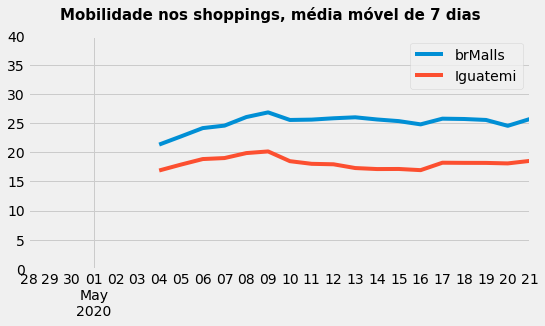

In [20]:
# =============================================================================
# Chart - Weighted mean ocupation rate, 7 days moving average
# =============================================================================

# 7 days moving average
fig, ax = plt.subplots(1, 1, figsize = (8, 4))
fig.suptitle('Mobilidade nos shoppings, média móvel de 7 dias', fontsize=15, horizontalalignment = 'center', weight = 'bold')
(data_chart * 100).iloc[:, :].rolling(7).mean().plot(ax = ax, ylim = (0, 40))

This is more noticeable after plotting the 7 days moving average of the same data.

### Heatmap
Valores em vermelho estão abaixo de 50% da frequência usual para o dia, em azul acima de 50% da frequência usual.

##### Iguatemi

In [30]:
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "6pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]
def color(val):
    if val == 0:
        return 'background-color: %s' % 'transparent'
    else:
        return ''
        

rename_cols = {x:x.strftime("%m/%d") for x in iguatemi_ocpRate.columns}
(iguatemi_receita_shopping_sales419.merge(iguatemi_ocpRate, left_index = True, right_index = True)\
    .reset_index()\
    .sort_values('sales_419', ascending = False)\
    .assign(sales_419 = lambda x: x.sales_419.apply("{0:.2f}%".format))\
    .rename(columns = {'sales_419':'% revenus'})\
    .set_index(['index', '% revenus']) * 100)\
    .iloc[:, :].rename(columns = rename_cols)\
    .fillna(0).style.background_gradient(cmap, axis=1, vmin = 0, vmax = 100)\
    .applymap(color)\
    .set_properties(**{'max-width': '80px', 'font-size': '1pt'})\
    .set_caption("Iguatemi")\
    .set_precision(2)\
    .set_table_styles(magnify())

,,04/28,04/29,04/30,05/01,05/02,05/03,05/04,05/05,05/06,05/07,05/08,05/09,05/10,05/11,05/12,05/13,05/14,05/15,05/16,05/17,05/18,05/19,05/20,05/21
index,% revenus,,,,,,,,,,,,,,,,,,,,,,,,
Iguatemi São Paulo,23.02%,13.97,18.17,14.18,7.21,12.08,13.17,19.93,16.11,20.15,15.81,15.07,15.81,3.12,16.56,16.82,17.19,14.95,14.17,13.19,9.94,17.08,18.63,12.77,11.80
Iguatemi Porto Alegre,14.33%,0.00,0.00,0.00,18.96,20.08,20.93,29.38,29.58,35.85,22.04,23.03,17.49,3.09,21.60,20.73,24.73,20.99,20.43,14.92,10.90,20.05,21.43,31.22,33.53
Iguatemi Campinas,13.87%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Shopping Pátio Higienópolis,11.19%,15.02,19.98,26.49,16.65,16.51,18.41,25.38,25.50,27.09,23.92,21.56,19.12,7.86,23.67,27.36,24.41,21.78,21.81,15.71,17.02,21.09,22.46,20.24,22.59
Shopping Iguatemi Esplanada,8.51%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Praia de Belas Shopping,6.56%,0.00,0.00,0.00,6.24,9.58,12.76,13.20,11.34,14.41,13.09,9.38,12.44,3.18,13.39,14.67,12.16,12.27,12.76,10.33,13.49,12.24,14.12,16.23,22.39
Iguatemi Brasília,4.83%,0.00,0.00,0.00,23.06,19.26,16.00,26.74,28.88,32.62,26.61,25.06,21.54,6.47,25.04,32.94,28.81,23.52,25.94,20.01,16.86,21.36,23.32,25.64,25.27
Shopping Iguatemi Alphaville,4.73%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Market Place,4.45%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


##### brMalls

In [27]:
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "6pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

def color(val):
    if val == 0:
        return 'background-color: %s' % 'transparent'
    else:
        return ''

rename_cols = {x:x.strftime("%m/%d") for x in brmalls_ocpRate.columns}
(brmalls_receita_shopping_sales419.merge(brmalls_ocpRate, left_index = True, right_index = True)\
    .reset_index()\
    .sort_values('sales_419', ascending = False)\
    .assign(sales_419 = lambda x: x.sales_419.apply("{0:.2f}%".format))\
    .rename(columns = {'sales_419':'% revenues'})\
    .set_index(['shopping', '% revenues']) * 100)\
    .iloc[:, :].rename(columns = rename_cols)\
    .fillna(0).style.background_gradient(cmap, axis=1, vmin = 0, vmax = 100)\
    .applymap(color)\
    .set_properties(**{'max-width': '80px', 'font-size': '1pt'})\
    .set_caption("BR Malls")\
    .set_precision(2)\
    .set_table_styles(magnify())

,,04/28,04/29,04/30,05/01,05/02,05/03,05/04,05/05,05/06,05/07,05/08,05/09,05/10,05/11,05/12,05/13,05/14,05/15,05/16,05/17,05/18,05/19,05/20,05/21
shopping,% revenues,,,,,,,,,,,,,,,,,,,,,,,,
Shopping Recife,8.38%,22.69,24.20,20.74,16.89,17.69,15.58,20.13,18.93,23.15,21.67,22.15,22.69,3.35,19.62,23.55,24.39,20.48,20.04,18.39,9.58,18.32,18.66,9.92,23.06
NorteShopping,6.82%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Shopping Plaza Niterói,5.53%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Shopping Tijuca,4.89%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
São Luís Shopping,4.15%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Catuai Shopping Maringá,4.15%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,38.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Araguaia Shopping,4.15%,30.10,35.99,30.64,20.73,16.52,18.25,31.44,34.71,35.72,31.50,30.84,22.58,16.67,30.22,35.23,36.98,27.85,26.35,19.51,7.93,28.94,30.23,23.97,35.58
Shopping Vila Velha,4.13%,6.72,12.10,32.75,15.21,24.91,22.46,30.02,29.74,37.40,32.84,31.65,27.93,11.99,28.17,30.56,33.78,27.15,28.41,22.73,23.31,25.83,27.75,33.05,37.11
Shopping Tamboré,4.04%,0.00,0.00,0.00,28.61,33.68,19.53,36.19,34.80,41.00,43.23,46.20,47.22,12.58,41.00,41.63,49.18,37.88,33.56,37.48,23.05,39.91,38.50,38.05,45.41


Some closed malls (e.g., Shopping Morumbi) reported a mobiliy value greater than zero, which partially shows their strategy to sell on [drive tru](https://www1.folha.uol.com.br/mercado/2020/05/drive-thru-cresce-com-alternativa-de-shoppings-e-lojas-para-reduzir-perdas.shtml).

The heatmaps show a more geographically diversified portfolio for brMalls. It has a bigger proportion of shopping centers in states softening quarantine measures, compared to Iguatemi - and this malls represent a relevant fraction of its revenues. This seems the main reason to lead brMalls to retain more of its mobility.

### How this values are calculated?
The values showed above are the ratio between the historic mobility score and the current value collected for the period scrapping Google Maps. If value < 100, then the mobility score is beneath its usual value, if value > 100 then it's above its usual value (examples below)

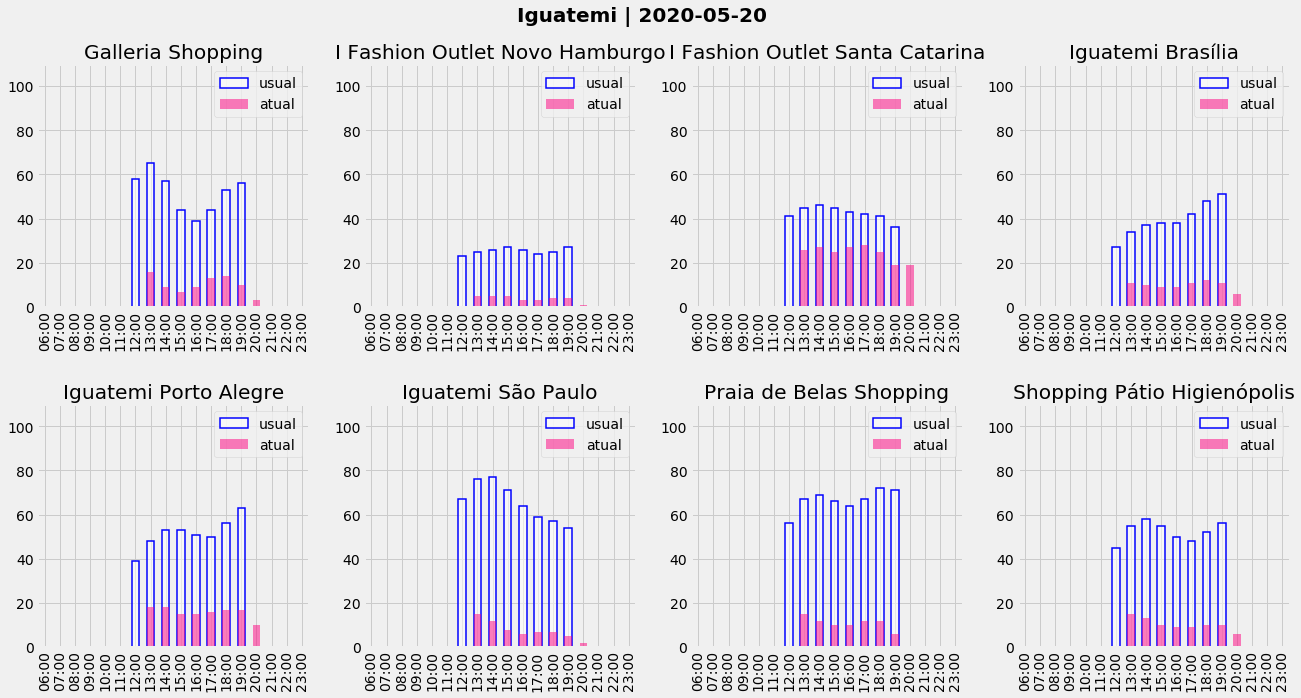

In [37]:
# Example 1
def createList(string):
    
    output = pd.DataFrame({'usual':output_live0.T[string], 
                           'atual':output_live1.T[string]})
    
    return [string, output]

date_plot = '2020-05-20'
output_live1, output_live0 = byHour(tbdict, 'iguatemi', date_plot)

ncols = 4
nrows = ceil(len(output_live1) / 4)

fig, axs = plt.subplots(nrows, ncols, figsize = (20, 5 * nrows))
plt.subplots_adjust(wspace = 0.2, hspace = 0.4)
fig.suptitle(f"Iguatemi | {date_plot}", fontsize = 20, x=0.5, y=0.96, horizontalalignment = 'center', weight = 'bold')

flat_list = [item for sublist in axs for item in sublist]

for data, ax in zip([createList(x) for x in output_live0.index], flat_list):
    
    data[1].plot(y = 'usual', kind = 'bar', ax = ax, color = (1, 1, 1, 0.5), edgecolor = 'blue', linewidth = 1.5, ylim = (0, 110))
    data[1].plot(y = 'atual', kind = 'bar', ax = ax, color = (1, 0, 0.5, 0.5), ylim = (0, 110))
    
    ax.title.set_text(f'{data[0]}')

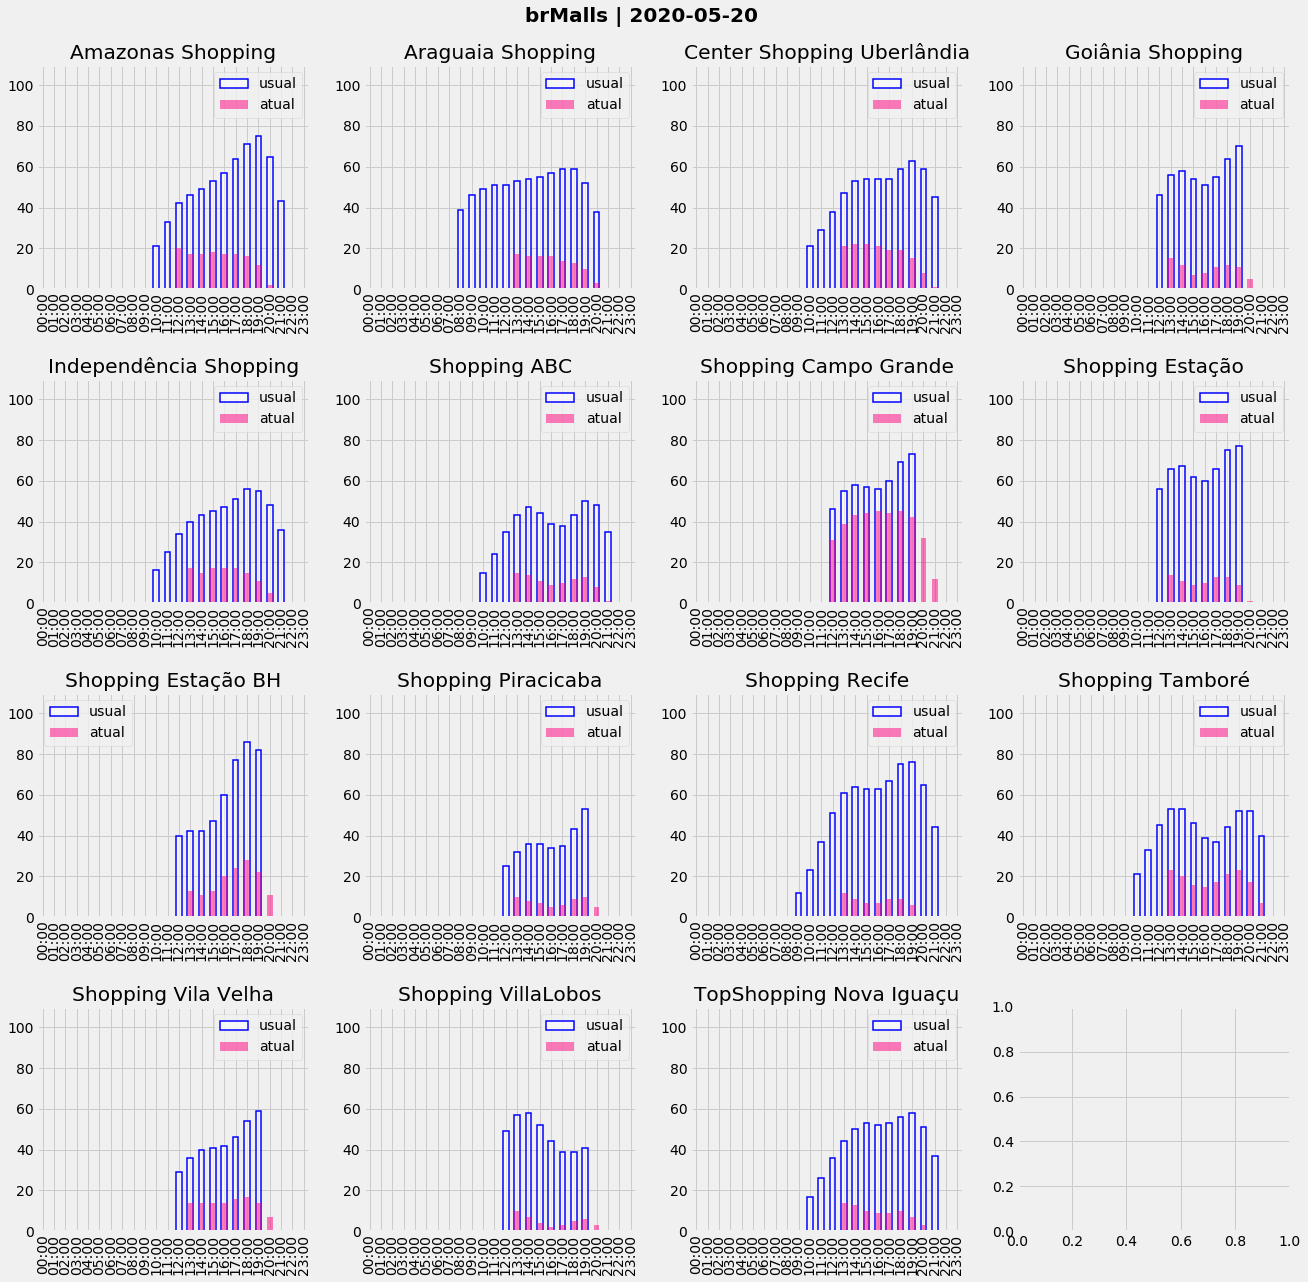

In [36]:
# Example
date_plot = '2020-05-20'
output_live1, output_live0 = byHour(tbdict, 'brmalls', date_plot)

ncols = 4
nrows = ceil(len(output_live1) / 4)

fig, axs = plt.subplots(nrows, ncols, figsize = (20, 5 * nrows))
plt.subplots_adjust(wspace = 0.2, hspace = 0.4)
fig.suptitle(f"brMalls | {date_plot}", fontsize = 20, x=0.5, y=0.92, horizontalalignment = 'center', weight = 'bold')

flat_list = [item for sublist in axs for item in sublist]

for data, ax in zip([createList(x) for x in output_live0.index], flat_list):
    
    data[1].plot(y = 'usual', kind = 'bar', ax = ax, color = (1, 1, 1, 0.5), edgecolor = 'blue', linewidth = 1.5, ylim = (0, 110))
    data[1].plot(y = 'atual', kind = 'bar', ax = ax, color = (1, 0, 0.5, 0.5), ylim = (0, 110))
    
    ax.title.set_text(f'{data[0]}')